MC First Visit: 100%|██████████| 5000/5000 [00:04<00:00, 1164.56it/s]



MC First Visit Results:
  Variance: 0.0000, Sample Efficiency: 0, Time/Episode: 0.0009s


MC Every Visit: 100%|██████████| 5000/5000 [03:15<00:00, 25.54it/s]



MC Every Visit Results:
  Variance: 0.0000, Sample Efficiency: 0, Time/Episode: 0.0390s


TD(0) Q-Learning: 100%|██████████| 5000/5000 [00:02<00:00, 2335.15it/s]



TD(0) Q-Learning Results:
  Variance: 0.0000, Sample Efficiency: 0, Time/Episode: 0.0004s


TD(lambda) SARSA: 100%|██████████| 5000/5000 [00:23<00:00, 209.21it/s]



TD(lambda) SARSA Results:
  Variance: 0.0000, Sample Efficiency: 0, Time/Episode: 0.0048s


TD(lambda) Q-Learning: 100%|██████████| 5000/5000 [00:23<00:00, 209.26it/s]



TD(lambda) Q-Learning Results:
  Variance: 0.0000, Sample Efficiency: 0, Time/Episode: 0.0048s


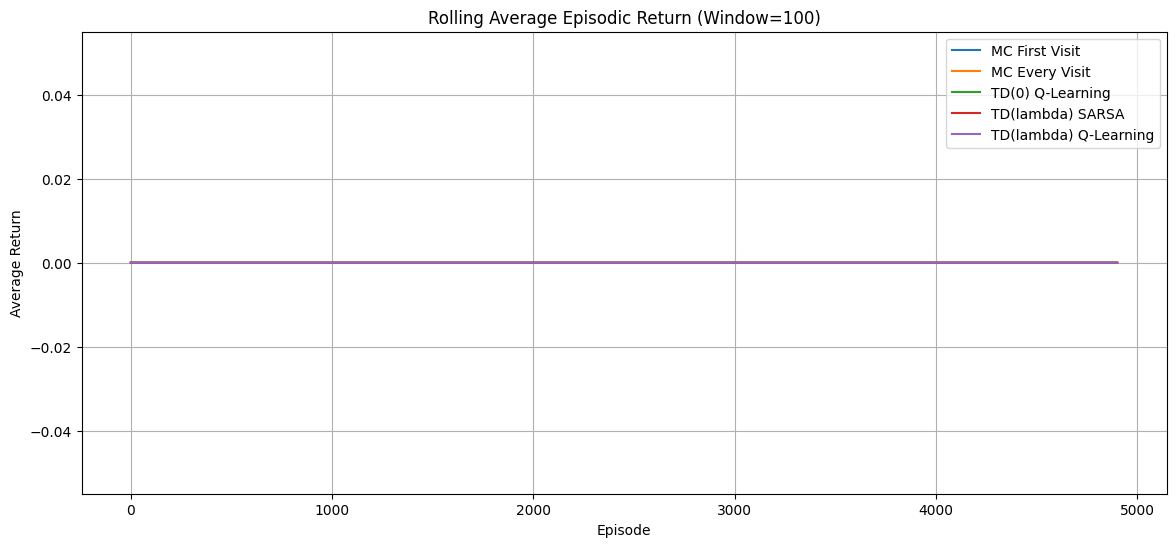

In [1]:
# === FROZENLAKE RL AGENTS: ALL AGENTS ===

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
import random

# ---- Helper: Rolling Average Plot ----
def plot_metric(metric_values, label, window=100):
    rolling_avg = np.convolve(metric_values, np.ones(window)/window, mode='valid')
    plt.plot(rolling_avg, label=label)

# ---- Metric Tracker ----
def evaluate_agent(rewards, times):
    rewards = np.array(rewards)
    variance = np.var(rewards)
    max_avg = np.max(np.convolve(rewards, np.ones(100)/100, mode='valid'))
    sample_eff = next((i for i, avg in enumerate(np.convolve(rewards, np.ones(100)/100, mode='valid')) if avg >= 0.9 * max_avg), -1)
    avg_time = np.mean(times)
    return variance, sample_eff, avg_time

# ---- Monte Carlo First Visit ----
def mc_first_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []

    for _ in tqdm(range(episodes), desc="MC First Visit"):
        start = time.time()
        state, _ = env.reset()
        episode = []
        done = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated

        G = 0
        visited = set()
        for s, a, r in reversed(episode):
            G = gamma * G + r
            if (s, a) not in visited:
                visited.add((s, a))
                returns[(s, a)].append(G)
                Q[s][a] = np.mean(returns[(s, a)])

        rewards_per_episode.append(sum([x[2] for x in episode]))
        times_per_episode.append(time.time() - start)

    return Q, rewards_per_episode, times_per_episode

# ---- Monte Carlo Every Visit ----
def mc_every_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []

    for _ in tqdm(range(episodes), desc="MC Every Visit"):
        start = time.time()
        state, _ = env.reset()
        episode = []
        done = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated

        G = 0
        for i in reversed(range(len(episode))):
            s, a, r = episode[i]
            G = gamma * G + r
            returns[(s, a)].append(G)
            Q[s][a] = np.mean(returns[(s, a)])

        rewards_per_episode.append(sum([x[2] for x in episode]))
        times_per_episode.append(time.time() - start)

    return Q, rewards_per_episode, times_per_episode

# ---- TD(0) Q-Learning ----
def td0_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(0) Q-Learning"):
        start = time.time()
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = np.argmax(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state = next_state
            total_reward += reward
            done = terminated or truncated

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)

    return Q, rewards_per_episode, times_per_episode

# ---- TD(lambda) with SARSA ----
def td_lambda_sarsa(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.9, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(lambda) SARSA"):
        start = time.time()
        state, _ = env.reset()
        action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
        E = defaultdict(lambda: np.zeros(env.action_space.n))
        total_reward = 0
        done = False

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[next_state])
            delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
            E[state][action] += 1
            for s in Q:
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= gamma * lam
            state = next_state
            action = next_action
            total_reward += reward
            done = terminated or truncated

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)

    return Q, rewards_per_episode, times_per_episode

# ---- TD(lambda) with Q-learning ----
def td_lambda_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.9, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(lambda) Q-Learning"):
        start = time.time()
        state, _ = env.reset()
        E = defaultdict(lambda: np.zeros(env.action_space.n))
        total_reward = 0
        done = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = np.argmax(Q[next_state])
            delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
            E[state][action] += 1
            for s in Q:
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= gamma * lam
            state = next_state
            total_reward += reward
            done = terminated or truncated

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)

    return Q, rewards_per_episode, times_per_episode

# ---- Main Runner ----
if __name__ == "__main__":
    env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True)

    agents = [
        ("MC First Visit", mc_first_visit),
        ("MC Every Visit", mc_every_visit),
        ("TD(0) Q-Learning", td0_q_learning),
        ("TD(lambda) SARSA", td_lambda_sarsa),
        ("TD(lambda) Q-Learning", td_lambda_q_learning)
    ]

    plt.figure(figsize=(14, 6))
    for name, agent in agents:
        Q, rewards, times = agent(env)
        var, eff, avg_time = evaluate_agent(rewards, times)
        plot_metric(rewards, name)
        print(f"\n{name} Results:\n  Variance: {var:.4f}, Sample Efficiency: {eff}, Time/Episode: {avg_time:.4f}s")

    plt.title("Rolling Average Episodic Return (Window=100)")
    plt.xlabel("Episode")
    plt.ylabel("Average Return")
    plt.legend()
    plt.grid()
    plt.show()


GreedyStrategy: 100%|██████████| 1000/1000 [00:00<00:00, 261311.07it/s]


Greedy Final Cumulative Reward: 1493.96, Optimal Action %: 0.00%


EpsilonGreedyStrategy: 100%|██████████| 1000/1000 [00:00<00:00, 320102.57it/s]


Epsilon Greedy Final Cumulative Reward: 2764.96, Optimal Action %: 86.70%


DecayingEpsilonGreedyStrategy: 100%|██████████| 1000/1000 [00:00<00:00, 312984.40it/s]


Decaying Epsilon Greedy Final Cumulative Reward: 3002.43, Optimal Action %: 99.10%


UCBStrategy: 100%|██████████| 1000/1000 [00:00<00:00, 83691.91it/s]


UCB Final Cumulative Reward: 2927.11, Optimal Action %: 91.00%


ThompsonSamplingStrategy: 100%|██████████| 1000/1000 [00:00<00:00, 64716.93it/s]


Thompson Sampling Final Cumulative Reward: 2533.78, Optimal Action %: 4.30%


PolicyGradientStrategy: 100%|██████████| 1000/1000 [00:00<00:00, 54930.18it/s]

Policy Gradient Final Cumulative Reward: 2947.17, Optimal Action %: 96.20%


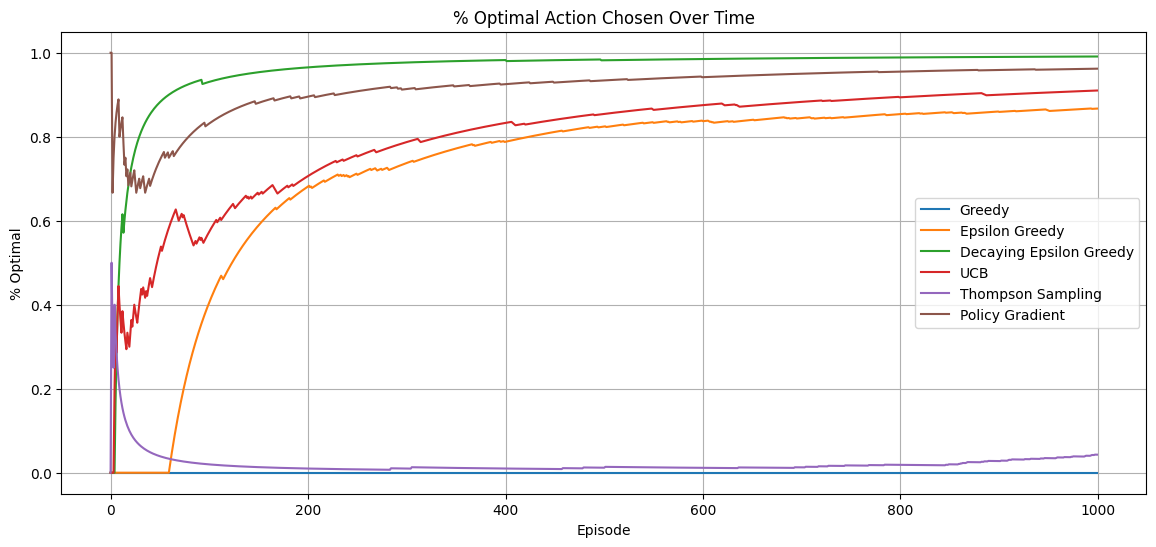

In [2]:
# === FROZENLAKE + BANDITS RL AGENTS ===

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim

# === BANDIT ENVIRONMENT ===
class MultiArmedBanditEnv(gym.Env):
    def __init__(self, n_arms, means, stds):
        super(MultiArmedBanditEnv, self).__init__()
        self.n_arms = n_arms
        self.means = means
        self.stds = stds
        self.action_space = gym.spaces.Discrete(n_arms)
        self.observation_space = gym.spaces.Discrete(1)

    def reset(self):
        return 0

    def step(self, action):
        reward = np.random.normal(self.means[action], self.stds[action])
        return 0, reward, True, {}

# === BANDIT AGENTS ===
def run_bandit_agent(env, strategy_fn, episodes=1000):
    rewards = []
    optimal_counts = []
    best_arm = np.argmax(env.means)
    strategy = strategy_fn(env.n_arms)

    for _ in tqdm(range(episodes), desc=type(strategy).__name__):
        action = strategy.select_action()
        _, reward, _, _ = env.step(action)
        strategy.update(action, reward)
        rewards.append(reward)
        optimal_counts.append(1 if action == best_arm else 0)

    return rewards, optimal_counts

# === Strategy Classes ===
class GreedyStrategy:
    def __init__(self, n_arms):
        self.n = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_action(self):
        return np.argmax(self.values)

    def update(self, arm, reward):
        self.n[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.n[arm]

class EpsilonGreedyStrategy:
    def __init__(self, n_arms, epsilon=0.1):
        self.n = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.epsilon = epsilon

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(self.n))
        return np.argmax(self.values)

    def update(self, arm, reward):
        self.n[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.n[arm]

class DecayingEpsilonGreedyStrategy:
    def __init__(self, n_arms):
        self.n = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.total_count = 0

    def select_action(self):
        epsilon = 1 / (1 + self.total_count)
        self.total_count += 1
        if np.random.rand() < epsilon:
            return np.random.randint(len(self.n))
        return np.argmax(self.values)

    def update(self, arm, reward):
        self.n[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.n[arm]

class UCBStrategy:
    def __init__(self, n_arms, c=2):
        self.n = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.total = 0
        self.c = c

    def select_action(self):
        self.total += 1
        ucb_values = [
            self.values[i] + self.c * np.sqrt(np.log(self.total + 1) / (self.n[i] + 1e-5))
            for i in range(len(self.n))
        ]
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.n[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.n[arm]

class ThompsonSamplingStrategy:
    def __init__(self, n_arms):
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)

    def select_action(self):
        samples = np.random.beta(self.alpha, self.beta)
        return np.argmax(samples)

    def update(self, arm, reward):
        reward = np.clip(reward, 0, 1)  # Ensure valid beta parameters
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward

class PolicyGradientStrategy:
    def __init__(self, n_arms, alpha=0.1):
        self.n_arms = n_arms
        self.alpha = alpha
        self.preferences = np.zeros(n_arms)
        self.probs = self._softmax()

    def _softmax(self):
        e = np.exp(self.preferences - np.max(self.preferences))
        return e / np.sum(e)

    def select_action(self):
        self.probs = self._softmax()
        return np.random.choice(self.n_arms, p=self.probs)

    def update(self, arm, reward):
        baseline = np.dot(self.probs, self.preferences)
        for a in range(self.n_arms):
            self.preferences[a] += self.alpha * (reward - baseline) * ((1 if a == arm else 0) - self.probs[a])

# === MAIN: Run Bandit Agents ===
if __name__ == "__main__":
    # Set up Bandit Environment
    n_arms = 5
    means = [1.0, 1.5, 2.0, 2.5, 3.0]
    stds = [1.0] * n_arms
    bandit_env = MultiArmedBanditEnv(n_arms, means, stds)

    strategies = [
        ("Greedy", lambda n: GreedyStrategy(n)),
        ("Epsilon Greedy", lambda n: EpsilonGreedyStrategy(n, 0.1)),
        ("Decaying Epsilon Greedy", DecayingEpsilonGreedyStrategy),
        ("UCB", lambda n: UCBStrategy(n, 2)),
        ("Thompson Sampling", ThompsonSamplingStrategy),
        ("Policy Gradient", PolicyGradientStrategy)
    ]

    plt.figure(figsize=(14, 6))
    for name, strategy_fn in strategies:
        rewards, optimal_actions = run_bandit_agent(bandit_env, strategy_fn)
        cum_reward = np.cumsum(rewards)
        percent_optimal = np.cumsum(optimal_actions) / (np.arange(len(optimal_actions)) + 1)
        plt.plot(percent_optimal, label=name)
        print(f"{name} Final Cumulative Reward: {cum_reward[-1]:.2f}, Optimal Action %: {percent_optimal[-1]*100:.2f}%")

    plt.title("% Optimal Action Chosen Over Time")
    plt.xlabel("Episode")
    plt.ylabel("% Optimal")
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
import os
import random

# Simulate a Bandit Strategy (e.g., Thompson Sampling)
class SimpleBanditResponder:
    def __init__(self, responses):
        self.responses = responses
        self.success_counts = [1] * len(responses)
        self.failure_counts = [1] * len(responses)

    def select_action(self):
        samples = [random.betavariate(s, f) for s, f in zip(self.success_counts, self.failure_counts)]
        return int(max(range(len(samples)), key=lambda i: samples[i]))

    def update(self, action, reward):
        if reward == 1:
            self.success_counts[action] += 1
        else:
            self.failure_counts[action] += 1

# Sample response strategies for an event (can be replaced with real actions)
response_table = {
    "Unrecognized Person Detected": [
        "Unrecognized person at the door. Proceed with caution.",
        "Unknown visitor detected. Do you want to alert security?",
        "Stranger detected. Ignoring for now."
    ],
    "Animal Intrusion": [
        "Animal intrusion detected. Stay alert.",
        "Unidentified motion near property. Activating lights.",
        "Wildlife intrusion. Logging event."
    ]
}

# Instantiate a bandit responder for each complex event
bandit_agents = {
    event: SimpleBanditResponder(responses)
    for event, responses in response_table.items()
}

# Main handler
def event_handler(event_label):
    print(f"📡 Event Detected: {event_label}")
    
    if event_label in bandit_agents:
        agent = bandit_agents[event_label]
        action_idx = agent.select_action()
        response = agent.responses[action_idx]

        # Act (on real hardware use: os.system('say ...') or speaker API)
        print(f"🔊 Action Taken: {response}")

        # Simulate feedback (you could replace this with button click confirmation, etc.)
        simulated_feedback = random.choice([1, 0])  # Success/failure
        agent.update(action_idx, simulated_feedback)
        print(f"📈 Feedback: {'Success' if simulated_feedback else 'Ignored'}")

    else:
        # Static rule-based responses
        static_responses = {
            "Fire Alarm Detected": "Fire alarm detected! Evacuate immediately.",
            "Glass Breaking Sound": "Possible intrusion detected! Alerting security.",
            "Baby Crying": "Baby crying detected. Notifying guardian.",
            "Doorbell Ringing": "Doorbell detected. Please check the entrance.",
            "Gunshot Detected": "Gunshot detected! Take cover and call emergency services.",
            "Low Light Detection": "Low visibility detected. Turning on night mode.",
            "Face Mask Violation": "Face mask not detected! Please wear a mask.",
            "Crowd Density Exceeded": "High crowd density detected. Maintain social distancing.",
            "Suspicious Object Detected": "Unattended object detected. Please inspect.",
            "Motion Detected at Night": "Unauthorized movement detected! Security alert triggered."
        }

        response = static_responses.get(event_label, "Unknown event detected.")
        print(f"🔊 Action Taken: {response}")

# === DEMO USAGE ===
event_handler("Unrecognized Person Detected")
event_handler("Fire Alarm Detected")
event_handler("Animal Intrusion")

📡 Event Detected: Unrecognized Person Detected
🔊 Action Taken: Unknown visitor detected. Do you want to alert security?
📈 Feedback: Success
📡 Event Detected: Fire Alarm Detected
🔊 Action Taken: Fire alarm detected! Evacuate immediately.
📡 Event Detected: Animal Intrusion
🔊 Action Taken: Animal intrusion detected. Stay alert.
📈 Feedback: Success
